# Getting Started


In this example, we will show how to:
    
- Find existing ML datasets on the QCArchive. 
- Extract geometries and quantum chemical results from the datasets. 
- Evaluate ML models on existing datasets. 
- Compute new data using your own instance of QCArchive. 


The demonstration is organized into three ML examples:
    
- Unsupervised learning: use manifold learning to understand the structure of the QM7b, QM7b-T, and SN2 Reaction datasets. 
- Supervised learning: train a kernel model to predict atomization energies with the ANI-1 dataset, and test it on a COMP6 benchmark.
- Dataset creation: Make a new dataset and compute DFT energy labels and neural network predictions. 

## Connect to the database

<div>
<img src="https://qcarchive.molssi.org/images/molssi-logo.svg" alt="MolSSI" align="right" style="width: 120px;"/>

The [Molecular Sciences Software Institute](https://molssi.org) hosts the Quantum Chemistry Archive (QCArchive) and makes its data available to the entire Computational Molecular Sciences community free of charge. The QCArchive is both a database to view, analyze, and explore existing data as well as a live instance that continuously generates new data as directed by the community.
</div>
<br>

<div>
    <img src="https://qcarchive.molssi.org/images/QCArchiveDrop2.svg" alt="QCArchive" align="left" style="width: 120px;"/>

The primary interface to any QCArchive database is the the ``qcportal`` Python package which can be downloaded via pip (`pip install -e qcportal`) or conda (`conda install qcportal -c conda-forge`). 

(Documentation: http://docs.qcarchive.molssi.org/projects/QCPortal/en/stable/)

The primary interface to a database server is a through a ``FractalClient``. We can connect to api.qcarchive.molssi.org to get access to all data contained within the MolSSI server.

</div>

In [2]:
import numpy as np
import pandas as pd

import qcportal as ptl

client = ptl.FractalClient(address="api.qcarchive.molssi.org")
client

FractalClient(server_name='The MolSSI QCArchive Server', address='https://api.qcarchive.molssi.org/', username='None')

## Exploring collections

We organize datasets into "collections". QCArchive hosts many data collections, including benchmarks for electronic structure development, PES scans for force field fitting, in addition to the ML datasets discussed earlier. The `list_collections` function returns all of the collections on the server:

In [3]:
client.list_collections()

tagline
collection          name                                                                                      
Dataset             ANI-1                                    22 million off-equilibrium conformations and e...
                    COMP6 ANI-MD                             Benchmark containing MD trajectories from the ...
                    COMP6 DrugBank                           Benchmark containing DrugBank off-equilibrium ...
                    COMP6 GDB10to13                          Benchmark containing off-equilibrium molecules...
                    COMP6 GDB7to9                            Benchmark containing off-equilibrium molecules...
...                                                                                                        ...
TorsionDriveDataset OpenFF Primary TorsionDrive Benchmark 1                                               None
                    OpenFF Substituted Phenyl Set 1                                                       None
                    Pfizer Discrepancy Torsion Dataset 1                                                  None
                    SMIRNOFF Coverage Torsion Set 1                                                       None
                    TorsionDrive Paper                                                                    None

[82 rows x 1 columns]

Here we focus on machine learning datasets, searching for collections with the "machine learning" tag:

In [4]:
client.list_collections(tag="machine learning") 

tagline
collection name                                                                         
Dataset    ANI-1                       22 million off-equilibrium conformations and e...
           COMP6 ANI-MD                Benchmark containing MD trajectories from the ...
           COMP6 DrugBank              Benchmark containing DrugBank off-equilibrium ...
           COMP6 GDB10to13             Benchmark containing off-equilibrium molecules...
           COMP6 GDB7to9               Benchmark containing off-equilibrium molecules...
           COMP6 S66x8                           Benchmark for noncovalent interactions.
           COMP6 Tripeptides           Benchmark containing off-equilibrium geometrie...
           G-SchNet Generated           Molecules generated by G-SchNet, trained on QM9.
           GDB13-T                     Small organic molecules with up to 13 heavy at...
           GDML                        Molecular dynamics trajectories of small molec...
           ISO-17                      Molecular dynamics trajectories of isomers of ...
           QM7                         Small organic molecules with up to 7 heavy atoms.
           QM7b                        Small organic molecules with up to 7 heavy ato...
           QM7b-T                      Small organic molecules with up to 7 heavy ato...
           QM9                         Small organic molecules with up to 9 heavy ato...
           SN2 Reactions               Chemical reactions of methyl halides with hali...
           Solvated Protein Fragments             Amons derived from proteins, in water.

### These are the same as the ML datasets the QCArchive website

https://qcarchive.molssi.org/apps/ml_datasets

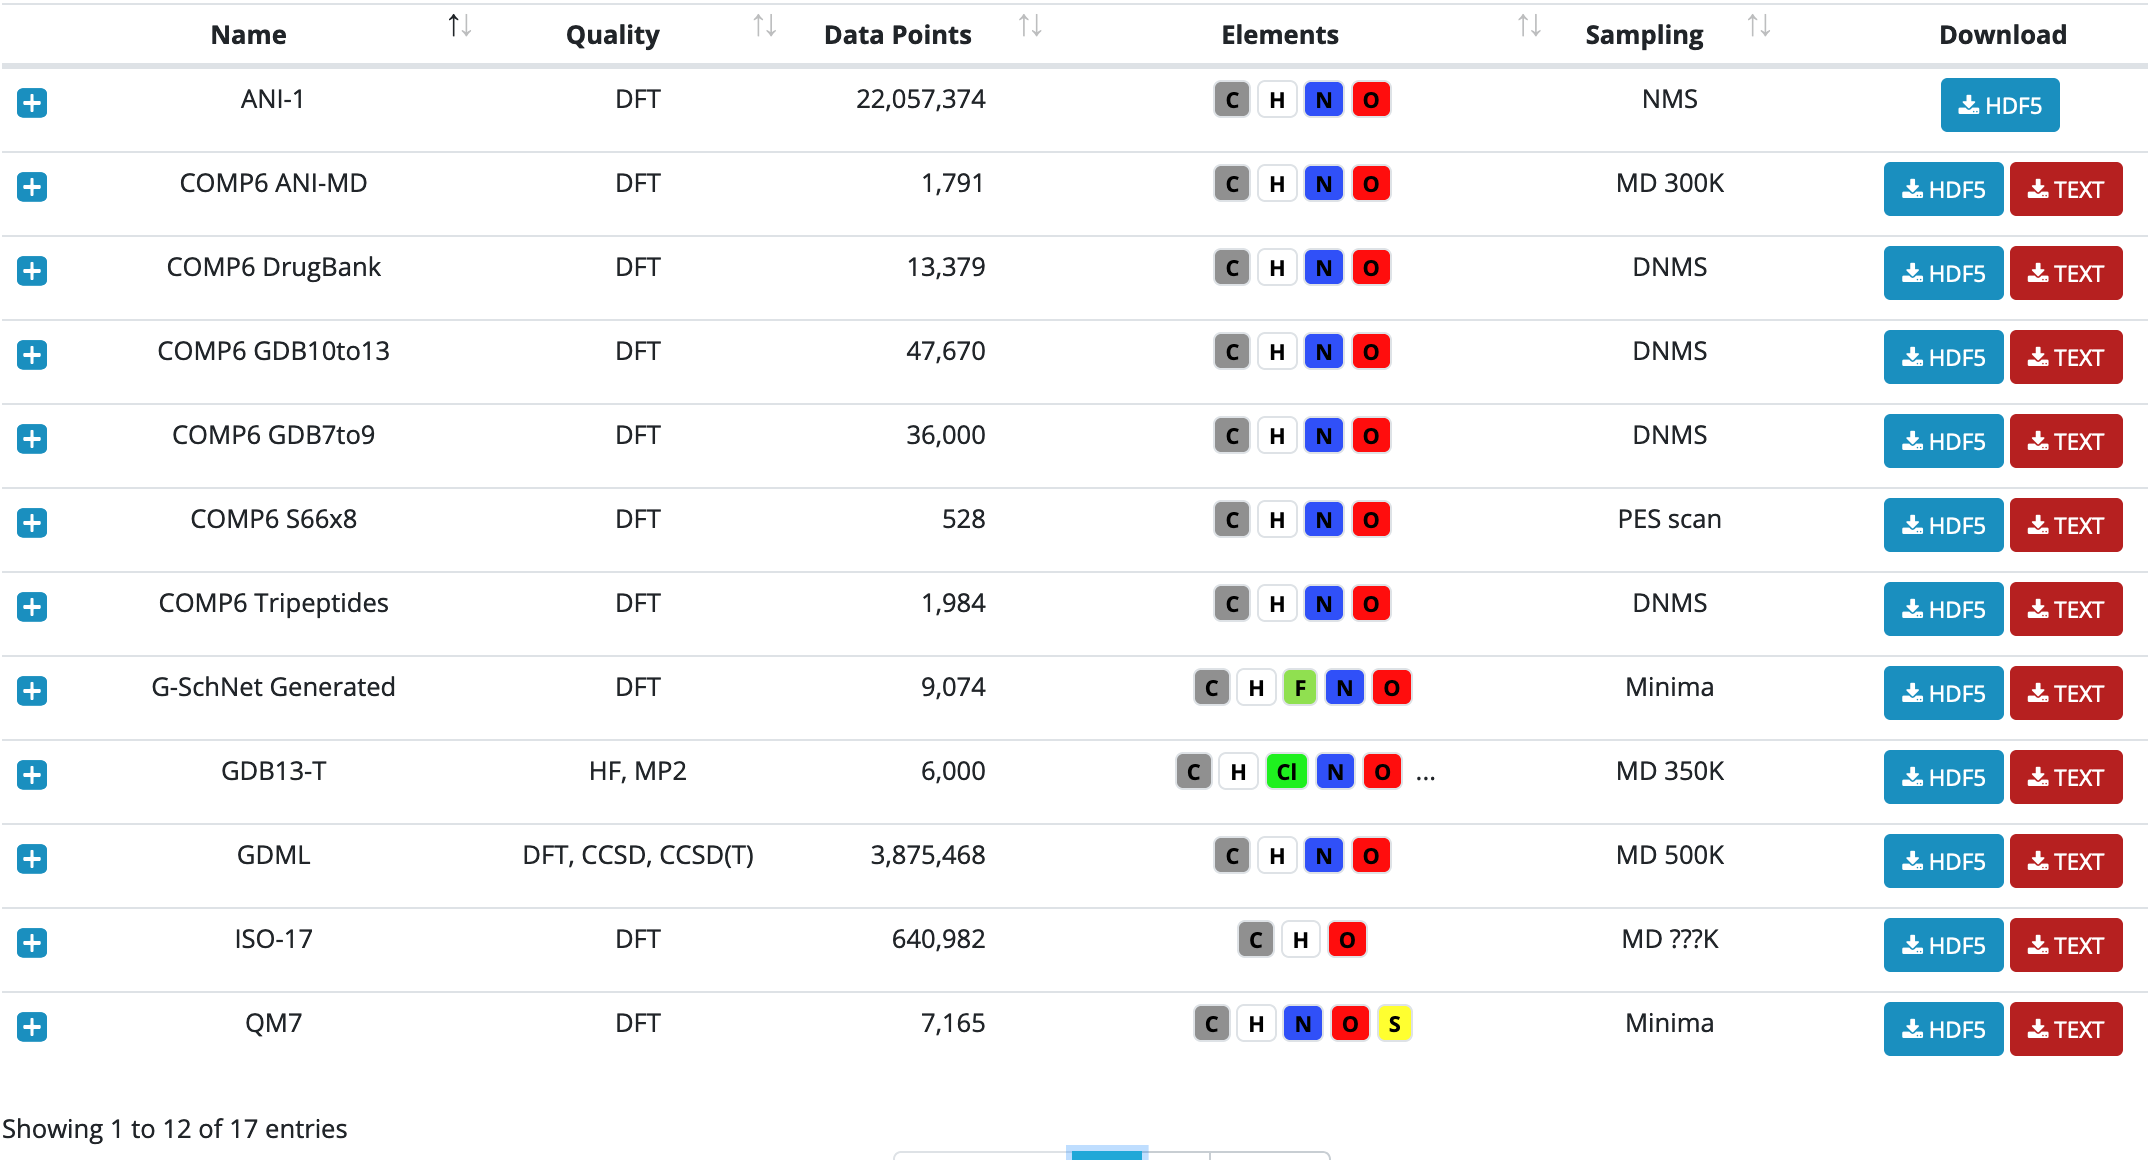

### Looking at the QM7b dataset

Collections can be obtained from the server with `get_collection`. 
A collection object is light-weight, initially containing only metadata; extremely large datasets (such as ANI-1) can be pulled in a few seconds. 
For this example, we will start with the QM7b dataset.
To obtain this collection:

In [6]:
qm7b = client.get_collection("dataset", "qm7b")
print_info(qm7b)

Name: QM7b

Data Points: 7211
Elements: ['C', 'H', 'Cl', 'N', 'O', 'S']
Labels: ['atomization energy', 'excitation energy', 'lumo', 'ionization potential', 'electron affinity', 'polarizability', 'absorption intensity', 'homo']


### Getting molecules

Datasets contain two types of data:

- Molecules: Representations of molecules, containing atoms, geometry, charge, spin, fragments, etc.
- Values: Properties of those molecules, such as the B3LYP/6-31G* energy

We can access the molecules in a dataset with the `get_molecules` function. This function returns a pandas `DataFrame` of `Molecule` objects.

In [7]:
qm7b_mols = qm7b.get_molecules()
qm7b_mols

,molecule
index,
0,"Geometry (in Angstrom), charge = 0.0, mult..."
1,"Geometry (in Angstrom), charge = 0.0, mult..."
10,"Geometry (in Angstrom), charge = 0.0, mult..."
100,"Geometry (in Angstrom), charge = 0.0, mult..."
1000,"Geometry (in Angstrom), charge = 0.0, mult..."
...,...
995,"Geometry (in Angstrom), charge = 0.0, mult..."
996,"Geometry (in Angstrom), charge = 0.0, mult..."
997,"Geometry (in Angstrom), charge = 0.0, mult..."


### Visualizing molecules

Individual `Molecule` objects can be directly displayed in a Jupyter notebook:

In [8]:
qm7b_mols["molecule"][100]  # get the element in column "molecule", row 100

_ColormakerRegistry()

NGLWidget()

### Listing values

The `list_values` function shows what data are available in a collection. QM7b is fairly data rich, containing ground and excited state properties at the ZINDO, DFT, and GW levels.

In [9]:
qm7b.list_values()

keywords  \
native driver         program  method                    basis                      
False  e1             Orca     ZINDO                     Unknown          Unknown   
       ea             Orca     ZINDO/s                   Unknown          Unknown   
       emax           Orca     ZINDO                     Unknown          Unknown   
       energy         FHI-aims pbe0                      Unknown          Unknown   
       homo           FHI-aims GW                        Unknown          Unknown   
                               pbe0                      Unknown          Unknown   
                      Orca     ZINDO/s                   Unknown          Unknown   
       imax           Orca     ZINDO                     Unknown          Unknown   
       ip             Orca     ZINDO/s                   Unknown          Unknown   
       lumo           FHI-aims GW                        Unknown          Unknown   
                               pbe0                      Unknown          Unknown   
                      Orca     ZINDO/s                   Unknown          Unknown   
       polarizability FHI-aims Self-consistent screening Unknown          Unknown   
                               pbe0                      Unknown          Unknown   
True   energy         psi4     b2plyp                    aug-cc-pvdz  scf_default   
                                                         aug-cc-pvtz  scf_default   
                                                         def2-svp     scf_default   
                                                         def2-tzvp    scf_default   
                                                         sto-3g       scf_default   
                               b3lyp                     aug-cc-pvdz  scf_default   
                                                         aug-cc-pvtz  scf_default   
                                                         def2-svp     scf_default   
                                                         def2-tzvp    scf_default   
                                                         sto-3g       scf_default   
                               wb97m-v                   aug-cc-pvdz  scf_default   
                                                         aug-cc-pvtz  scf_default   
                                                         def2-svp     scf_default   
                                                         def2-tzvp    scf_default   
                                                         sto-3g       scf_default   

                                                                                                                 name  
native driver         program  method                    basis                                                         
False  e1             Orca     ZINDO                     Unknown                      First excitation energy (ZINDO)  
       ea             Orca     ZINDO/s                   Unknown                          Electron affinity (ZINDO/s)  
       emax           Orca     ZINDO                     Unknown      Excitation energy at maximal absorption (ZINDO)  
       energy         FHI-aims pbe0                      Unknown                        Atomization energy (DFT/PBE0)  
       homo           FHI-aims GW                        Unknown              Highest occupied molecular orbital (GW)  
                               pbe0                      Unknown            Highest occupied molecular orbital (PBE0)  
                      Orca     ZINDO/s                   Unknown         Highest occupied molecular orbital (ZINDO/s)  
       imax           Orca     ZINDO                     Unknown                 Maximal absorption intensity (ZINDO)  
       ip             Orca     ZINDO/s                   Unknown                       Ionization potential (ZINDO/s)  
       lumo           FHI-aims GW                        Unknown             Lowest unoccupied molecular orbital (GW)

### Getting values

The `get_values` function pulls a data column down from the server. Values may be filtered by any of the fields described in `list_values`, including `driver`, `program`, `method`, `basis`, and `name`. Here, we show all calculation performed with the B3LYP functional.

In [10]:
qm7b.units = "hartree"
qm7b.get_values(method="b3lyp")

,B3LYP/sto-3g,B3LYP/aug-cc-pvdz,B3LYP/def2-tzvp,B3LYP/def2-svp,B3LYP/aug-cc-pvtz
0,-40.0392,-40.5206,-40.5375,-40.4878,-40.5383
1,-78.8861,-79.8361,-79.8638,-79.7717,-79.8645
10,-131.067,-132.771,-132.81,-132.655,-132.808
100,-207.419,-210.09,-210.147,-209.908,-210.146
1000,-281.606,-285.326,-285.403,-285.072,-285.4
...,...,...,...,...,...
995,-282.86,-286.575,-286.651,-286.32,-286.649
996,-282.895,-286.656,-286.734,-286.405,-286.731
997,-282.861,-286.576,-286.652,-286.321,-286.65
998,-284.106,-287.805,-287.882,-287.549,-287.881


### Summary of QCPortal commands

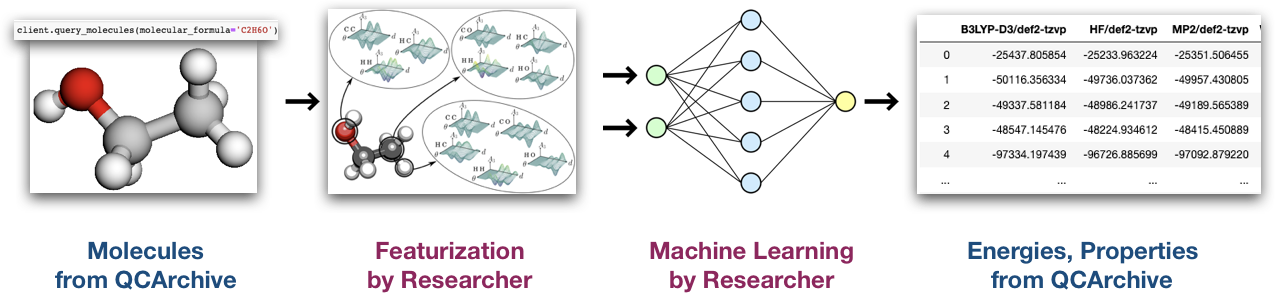

QCPortal is a Python interface to ML data hosted by MolSSI's QCArchive. Accessing the data requires only five commands.

    client = ptl.FractalClient()
    ds = client.get_collection("dataset", name)
    ds.get_molecules()
    ds.list_values()
    ds.get_values()
    

## Extras

In [ ]:
from IPython.core.display import HTML

def print_info(dataset):
    print(f"Name: {dataset.data.name}")
    print()
    print(f"Data Points: {dataset.data.metadata['data_points']}")
    print(f"Elements: {dataset.data.metadata['elements']}")
    print(f"Labels: {dataset.data.metadata['labels']}")
    
    display(HTML("<u>Description:</u> " + dataset.data.description))
    
    for cite in dataset.data.metadata["citations"]:
        display(HTML(cite['acs_citation']))